In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
import math
from keras.utils import np_utils

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (test_x, test_y) = cifar10.load_data()

num_classes = 10
test_y_cls = np_utils.to_categorical(test_y,num_classes)

print("Size of:")
print("- Training-set:\t\t{}".format(len(x_train)))
print("- Test-set:\t\t{}".format(len(test_x)))

In [ ]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class_names = load_label_names()

def label_to_array(cls_true):
    true = cls_true.tolist()
    true_label = []
    for l in true:
        true_label += l
    return true_label
    

### Create Random Validation and train data

In [ ]:
combined_size = x_train.shape[0]
split_size = 0.2

In [ ]:
# Helper-function for splitting the combined data-set into a random training- and validation-set.

def random_training_set(split_size):
    
    train_size = int(combined_size*(1-split_size))

    # Create a randomized index into the full / combined training-set.
    idx = np.random.permutation(combined_size)

    # Split the random index into training- and validation-sets.
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]

    # Select the images and labels for the new training-set.
    train = x_train[idx_train, :]
    labels = y_train[idx_train, :]

    # Select the images and labels for the new validation-set.
    x_validation = x_train[idx_validation, :]
    y_validation = y_train[idx_validation, :]

    # Return the new training- and validation-sets.
    return train, labels, x_validation, y_validation


In [ ]:
# Split data into random training and validation data
train_x, train_y, validation_x, validation_y = random_training_set(split_size)

train_y_cls = np_utils.to_categorical(train_y,num_classes)
validation_y_cls = np_utils.to_categorical(validation_y,num_classes)

print (train_x.shape)
print (validation_x.shape)

In [ ]:
#Data Dimensions

# CIFAR-10 images are 32 pixels in each dimension.
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images:
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 10

input_shape = (img_size, img_size, num_channels)

In [ ]:
#Plotting Images

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
#Preparing Data
def data_prep(train, validation,test, subtract_pixel_mean):
    # Normalize Data
    train = train.astype('float32')/255
    validation = validation.astype('float32')/255
    test = test.astype('float32')/255
    
    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        train_mean = np.mean(train, axis=0)
        train -= train_mean
        validation -= train_mean
        test -= train_mean
        
    return train, validation, test


In [ ]:
# Subtract per pixel
subtract_pixel_mean = True

train_x, validation_x, test_x = data_prep(train_x, validation_x, test_x, subtract_pixel_mean)

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def augment_batches(batch_size, data):
    '''
    Return a total of `num` samples
    '''
    
    images=batch_size
    while(images + batch_size <= len(data)):
        prev_no = images
        images += batch_size
        data[prev_no:images] = crop_images(data[prev_no:images])
    
    return data


# Padding images to 36x36 then randomly crop 32x32 size images
def crop_images(train):
    
    # Zero pad images to 36x36 size
    train = tf.image.resize_with_crop_or_pad(train,
                                             target_height=36,
                                             target_width=36).numpy()
    train = tf.image.random_crop(train, size=[train.shape[0], 32, 32, 3])
    
    return train.numpy()

    

In [ ]:
## Random crop images
random_crop = False

if (random_crop):
    train_x = augment_batches(train_x, 128)

In [ ]:
# Get the first 9 images from the test-set.
images = train_x[0:9]

# Get the true classes for those images.
cls_true = train_y[0:9]
cls_true = label_to_array(cls_true)

# Plot the images and labels using our helper-function above.
plot_images(images, cls_true)


### Import Required Libraries

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, Add
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam

### Define an Identity Block
The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$)

#### Note: 34 layer Residual Network uses only 3x3 conv layers

#### Architecture for different residual networks is given below
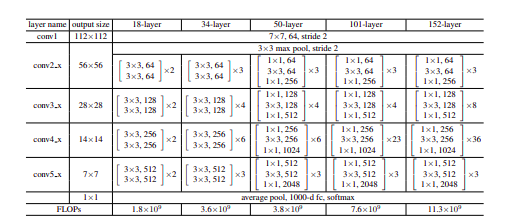

In [ ]:
def identity_block(net, shape, filters, stage, block):
    '''
    Arguments: 
    1. net -- input tensor of shape(m, h_prev, w_prev, c_prev)
    2. shape -- integer, specifying the shape of the middle CONV's
    window for the main path
    3. filters -- list of integers, defining the no of filters of 
    CONV layers in the main path
    4. stage -- integer, used to name the layers depending on their 
    position in the network
    5. block -- string/character used to name the layers depending
    on their position in the network
    
    Returns:
    net -- output of the identity block, tensor of shape
    (h_curr, w_curr, c_curr)
    '''
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + str(block) + '_branch'
    bn_name_base = 'bn' + str(stage) + str(block) + '_branch'
    
    # Retrieve filters
    # we are using two conv layers hence
    F1, F2 = filters
    
    # Save input value to be used as shortcut to add to main path
    net_shortcut = net
    
    ## Main Path
    # First component
    net = Conv2D(filters=F1, kernel_size=(shape,shape),
                 name = conv_name_base + '2a',
                 strides=(1,1), padding='same')(net)
    net = BatchNormalization(axis = 3, name = bn_name_base + '2a')(net)
    net = Activation('relu')(net)
    
    ## Second component
    net = Conv2D(filters=F2, kernel_size=(shape,shape),
                 name = conv_name_base + '2b',
                 strides=(1,1), padding='same')(net)
    net = BatchNormalization(axis = 3, name = bn_name_base + '2b')(net)
    
    # Final step: Add shortcut value to main path, 
    # and pass it through a RELU activation
    
    net = Add()([net, net_shortcut])
    net = Activation('relu')(net)
    
    return net

### Convolution Block
#### This is used when the output the dimension is different than the input dimension in a layer
This block is used when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path which is used to resize the net to a different dimension, so that the dimensions add up for the final addition when the shortcut is added to the main path

In [ ]:
def convolutional_block(net, shape, filters, stage, block, s=2):
    '''
    Arguments: 
    1. net -- input tensor of shape(m, h_prev, w_prev, c_prev)
    2. shape -- integer, specifying the shape of the middle CONV's
    window for the main path
    3. filters -- list of integers, defining the no of filters of 
    CONV layers in the main path
    4. stage -- integer, used to name the layers depending on their 
    position in the network
    5. block -- string/character used to name the layers depending
    on their position in the network
    6. s -- Integer specifying the stride to be used
    
    Returns:
    net -- output of the identity block, tensor of shape
    (h_curr, w_curr, c_curr)
    '''
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + str(block) + '_branch'
    bn_name_base = 'bn' + str(stage) + str(block) + '_branch'
    
    # Retrieve filters
    # we are using two conv layers hence
    F1, F2 = filters
    
    # Save input value to be used as shortcut to add to main path
    net_shortcut = net
    
    ## Main Path
    # First component
    net = Conv2D(filters=F1, kernel_size=(shape,shape),
                 name = conv_name_base + '2a',
                 strides=(s,s), padding='same')(net)
    net = BatchNormalization(axis = 3, name = bn_name_base + '2a')(net)
    net = Activation('relu')(net)
    
    ## Second component
    net = Conv2D(filters=F2, kernel_size=(shape,shape),
                 name = conv_name_base + '2b',
                 strides=(1,1), padding='same')(net)
    net = BatchNormalization(axis = 3, name = bn_name_base + '2b')(net)
    
    ## Shortcut Path
    net_shortcut = Conv2D(filters=F2, kernel_size=(1,1), strides=(s,s),
                         padding='valid',
                         name = conv_name_base + '1')(net_shortcut)
    net_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(net_shortcut)
    
    # Final step: Add shortcut value to main path, 
    # and pass it through a RELU activation
    
    net = Add()([net, net_shortcut])
    net = Activation('relu')(net)
    
    return net

## Bulding ResNet20 Model 
### Structure
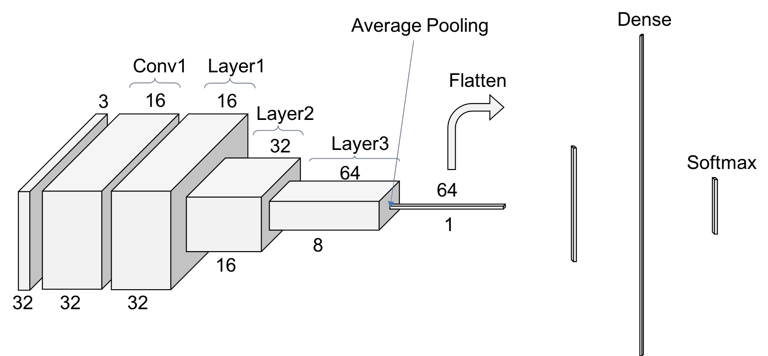

#### Convolution 1: 
16 3x3 filters with stride = 1 and padding = 'same' followed by BatchNormalization
Output = 32x32x16

#### Layer 1
2 Convolutions with 16 3x3 filters each. 
Output = 32x32x16

#### Layer 2
2 Convolutions with 32 3x3 filters each.
First convolution uses a stride 2 hence output vol is half the input volume.
Output = 16x16x32

#### Layer 3
2 Convolutions with 64 3x3 filters each.
First convolution uses a stride 2 hence output vol is half the input volume.
Output = 8x8x64

#### The down sampling of the volumes is achieved by increasing the stride to 2 for the first convolution of each layer, hence no pooling operations is used

In [ ]:
## ResNet 20
def ResNet(input_shape, depth, num_classes):
    """
    Implementation of the ResNet20 having the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> IDBLOCK*2 -> 
    IDBLOCK*2 -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    depth -- No of convolutions layers in the network (including start and end layers)
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    if (depth-2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
        
    # Define a tensor with input shape
    inputs = Input(input_shape)
    
    # Stage 1 --> 3x3 Convolution with 16 filters and stride 1
    net = Conv2D(16, (3,3), strides=(1,1), padding='same',
                name='conv1')(inputs)
    net = BatchNormalization(axis=3, name='bn_conv1')(net)
    net = Activation('relu')(net)
    
    num_blocks_per_layer = int((depth-2)/6)
    num_filters = 16
    
    for stage in range(3):
        block = 0
        
        while block < num_blocks_per_layer:
            
            if stage>0 and block==0: # First block of later layers which need downsampling
                net = convolutional_block(net, shape=3, filters=[num_filters,num_filters], stage=stage, block=block, s=2)
                block += 1
                
            net = identity_block(net, shape=3, filters=[num_filters,num_filters], stage=stage, block=block)
            block += 1
            
        num_filters *= 2
            
    # Global Average Pooling
    net = AveragePooling2D((2,2), name="avg_pool")(net)
    
    # Flatten Layer
    net = Flatten()(net)
    
    # Output Layer
    net = Dense(num_classes, activation='softmax', name='fc')(net)
    
    # Create Model
    model = Model(inputs=inputs, outputs=net, name='ResNet{}'.format(depth))
    
    return model
    
    

In [ ]:
# Creating Model
model = ResNet(input_shape, 20, num_classes)

In [ ]:
num_epochs = 50

# Initialize the optimizer and compile the model
optimizer = SGD(lr=0.0, momentum=0.9, decay=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer,
             metrics=['accuracy'])


## Step Decay
By using step decay, we schedule drop the learning rate by a factor every few epochs.

#### Is useful when training for long epochs

In [ ]:
# Define step decay function
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 40.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

# learning schedule callback
loss_history = LossHistory()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

In [ ]:
model.summary()

### Training the Model

In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    h = model.fit(train_x,
                  train_y_cls,
                  batch_size = 128,
                  validation_data=(validation_x,validation_y_cls)
                  callbacks=callbacks_list, 
                  epochs = num_epochs,
                  verbose = 1)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_x)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train_x, train_y_cls, batch_size=128),
                        validation_data=(validation_x, validation_y_cls),
                        epochs=num_epochs, verbose=1, workers=4,
                        callbacks=callbacks_list)

In [ ]:
result = model.evaluate(test_x, test_y_cls)

In [ ]:
#Predict on test_set
pred_y = model.predict(test_x)
pred_cls = np.argmax(pred_y, axis=1)

In [ ]:
#Some predicted Images
# Get the first 9 images from the test-set.
images = test_x[0:9]

# Get the true classes for those images.
cls_true = test_y[0:9]
cls_true = label_to_array(cls_true)

#Get Predicted Classes
cls_pred = pred_cls[0:9]
cls_pred = cls_pred.tolist()

# Plot the images and labels using our helper-function above.
plot_images(images, cls_true, cls_pred)